In [2]:
import sys, os, re, gzip, json, pickle, shutil, random
sys.path.append('../app')
from config import Config

from collections import Counter

import numpy as np

from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#from fse.models import SIF
#from fse import IndexedList

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [3]:
config = Config()

In [4]:
class_labels = ['Commercial', 'Fearmonger', 'HashtagGamer', 'LeftTroll', 
                'NewsFeed', 'NormalUser', 'RightTroll', 'Unknown']

with gzip.open(config.feature_x_path, 'rb') as fz:
    feats = pickle.load(fz)

#string labels for all 8 types
type_labels = [feat['type'] for feat in feats]
type_lab2idx = {c:i for i,c in enumerate(class_labels)}

#string binary labels
bin_labels = [l if l=='NormalUser' else 'TrollUser' for l in type_labels]
bin_lab2idx = {'NormalUser':0, 'TrollUser':1}

with open(config.feature_y_path, 'rb') as f:
    #int binary labels
    bin_y = pickle.load(f)
    
#int labels for all 8 types
type_y = [lab2idx[l] for l in type_labels]     

len(feats), len(bin_y)

(1000000, 1000000)

In [5]:
#a subset of data consisting of only NormalUser, LeftTroll, RightTroll
three_class_lab2int = {'LeftTroll':0, 'NormalUser':1, 'RightTroll':2}

three_class_feats = [f for f in feats if f['type'] in three_class_lab2int]
three_class_labels = [f['type'] for f in three_class_feats]
three_class_y = [three_class_lab2int[l] for l in three_class_labels]

len(three_class_feats), len(three_class_labels), len(three_class_y)

(765127, 765127, 765127)

In [6]:
#lemmas = [f['lemmas'].strip() for f in feats]
tokens = [f['tokens'].strip() for f in feats]

In [7]:
def train_w2v(texts, model_path, vec_dim=128, window=5):
    model = Word2Vec(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained word2vec model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model


def train_ft(texts, model_path, vec_dim=128, window=5):
    model = FastText(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained fasttext model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model

In [8]:
token_texts = [[t for t in l.split(' ') if t and not t[0]=='#'] for l in tokens]

In [14]:
word_vec_dim = 128

In [9]:
w2v_token_128_model = train_w2v(token_texts, model_path='w2v_token_%d.model' % word_vec_dim, 
                                vec_dim=word_vec_dim, window=5)

...Storing trained word2vec model
close to one
   all, 0.531845
   that, 0.526677
   One, 0.522539
   the, 0.522073
   probably, 0.515429
   every, 0.515309
   actually, 0.510083
   rest, 0.507020
   ever, 0.506661
   earth, 0.505416
close to cat
   dog, 0.798502
   kid, 0.701612
   girl, 0.691865
   mom, 0.682723
   puppy, 0.677790
   pig, 0.670335
   baby, 0.662166
   neighbor, 0.658788
   pet, 0.658629
   stomach, 0.653281
close to fun
   great, 0.701722
   nice, 0.682614
   awesome, 0.640763
   wonderful, 0.639966
   lovely, 0.639589
   good, 0.633600
   yummy, 0.632005
   fantastic, 0.620747
   cool, 0.607066
   fabulous, 0.586966
close to stupid
   dumb, 0.843443
   nasty, 0.705477
   annoying, 0.698032
   silly, 0.695454
   ridiculous, 0.679609
   weird, 0.668598
   lame, 0.661439
   crazy, 0.659034
   funny, 0.655009
   boring, 0.652486
close to lol
   haha, 0.871714
   lmao, 0.867576
   hahaha, 0.792742
   smh, 0.756514
   tho, 0.754352
   Lol, 0.753319
   :p, 0.722850
   lmfa

In [10]:
ft_token_128_model = train_ft(token_texts, model_path='ft_token_%d.model' % word_vec_dim, 
                              vec_dim=word_vec_dim, window=5)

...Storing trained fasttext model
close to one
   fone, 0.808282
   none, 0.766799
   lone, 0.744887
   throne, 0.740066
   tone, 0.737139
   cone, 0.736137
   noone, 0.731479
   ozone, 0.728656
   Ozone, 0.728233
   clone, 0.722626
close to cat
   dog, 0.830231
   goat, 0.806488
   belly, 0.778014
   beard, 0.777001
   doggy, 0.770091
   doggie, 0.769193
   mat, 0.766632
   bone, 0.765334
   pet, 0.765020
   catfish, 0.763890
close to fun
   great, 0.712751
   awesome, 0.702640
   funky, 0.699654
   funn, 0.685181
   fabulous, 0.676436
   wonderful, 0.670345
   funk, 0.663538
   nice, 0.663520
   gruesome, 0.660641
   good, 0.657015
close to stupid
   stupidly, 0.878712
   stupidity, 0.792253
   annoying, 0.788235
   disgusting, 0.767651
   pathetic, 0.751139
   silly, 0.749733
   fucking, 0.743266
   fugly, 0.742206
   weirdo, 0.741919
   ridiculous, 0.741697
close to lol
   lolol, 0.938090
   haha, 0.892991
   hahaha, 0.875494
   hahahha, 0.854620
   hahahaha, 0.848657
   hahah, 0.8

In [11]:
class LinearClassifier(nn.Module):
    def __init__(self, hid1_size, hid2_size, out_size, text_vocab_size, text_emb_dim, 
                 pos_vocab_size, pos_emb_dim, ent_vocab_size, ent_emb_dim, 
                 hashtag_vocab_size, hashtag_emb_dim, in_feat_dim, out_feat_dim):
        super().__init__()
        self.text_embedder = nn.EmbeddingBag(text_vocab_size, text_emb_dim)
        self.pos_embedder = nn.EmbeddingBag(pos_vocab_size, pos_emb_dim)
        self.ent_embedder = nn.EmbeddingBag(ent_vocab_size, ent_emb_dim)
        self.hashtag_embedder = nn.EmbeddingBag(hashtag_vocab_size, hashtag_emb_dim)
        self.feat_transform = nn.Linear(in_feat_dim, out_feat_dim)
        
        self.hid_layer1 = nn.Linear(text_emb_dim + pos_emb_dim + ent_emb_dim + hashtag_emb_dim + out_feat_dim, hid1_size)
        self.hid_layer2 = nn.Linear(hid1_size, hid2_size)
        self.out_layer = nn.Linear(hid2_size, out_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(hid1_size)
        self.batchnorm2 = nn.BatchNorm1d(hid2_size)
        
        
    def forward(self, x_text, x_pos, x_ent, x_hashtag, x_feats):
        text_emb = self.text_embedder(x_text)
        pos_emb = self.pos_embedder(x_pos)
        ent_emb = self.ent_embedder(x_ent)
        hashtag_emb = self.hashtag_embedder(x_hashtag)
        feat_trans = self.feat_transform(x_feats)
        
        x = torch.cat((text_emb, pos_emb, ent_emb, hashtag_emb, feat_trans), dim=1)
        x = self.dropout(x)
        
        x = self.relu(self.hid_layer1(x))
        x = self.batchnorm1(x)
        
        x = self.relu(self.hid_layer2(x))
        x = self.batchnorm2(x)
        
        x = self.out_layer(x)
        
        return F.log_softmax(x, dim=1)

In [12]:
def get_feature2idx_dicts(feats, word_model):
    word2idx = {}
    for i in range(len(word_model.wv.vocab)):
        word2idx[word_model.wv.index2word[i]] = i

    pos2idx = {}
    i=1
    for feat in feats:
        for pos in feat['pos'].split(' '):
            if not pos:
                continue
            if pos not in pos2idx:
                pos2idx[pos] = i
                i+=1
    pos2idx['<PAD>'] = 0

    ent2idx = {}
    i=1
    for feat in feats:
        for et in feat['ent_types']:
            #skip some bogus entity types
            if not et or not et.isupper():
                continue
            if et not in ent2idx:
                ent2idx[et] = i
                i+=1
    ent2idx['<PAD>'] = 0

    #only use hashtags with over 10 occurrences
    hashtags = []
    for feat in feats:
        hashtags.extend(feat['hashtags'])

    hashtag_cts = Counter(hashtags)
    hashtag_cts = {h:c for h,c in hashtag_cts.items() if c>=10}

    hashtag2idx = {h:i+1 for i,h in enumerate(hashtag_cts.keys())}
    hashtag2idx['<PAD>'] = 0

    feat_fields = ['emoji_ratio', 'link_ratio', 'user_ratio', 'oov_ratio']
    
    return word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields

In [13]:
word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields = get_feature2idx_dicts(feats, w2v_token_128_model)

In [31]:
def get_tensors(feats, word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields, lab2idx,
               text_seq_len = 30, ent_seq_len = 2, hashtag_seq_len = 2, 
                use_lemmas=False, reload=False):
    if reload and os.path.exists('y_type_%d.pt' % len(lab2idx)):
        x_text = torch.load('x_text.pt')
        x_pos = torch.load('x_pos.pt')
        x_ent = torch.load('x_ent.pt')
        x_hashtag = torch.load('x_hashtag.pt')
        x_feats = torch.load('x_feats.pt')
        y_bin = torch.load('y_bin.pt')
        y_type = torch.load('y_type_%d.pt' % len(lab2idx))
        
        return x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, y_type
    
    x_text = []
    x_pos = []
    x_ent = []
    x_hashtag = []
    x_feats = []
    y_bin = []
    y_type = []
    
    for feat in feats:
        #if feat['type'] not in lab2idx:
        #    continue

        if use_lemmas:
            #we use the actual word 'pad' as the pad token bc the pretrained wts must be the same size as the vocab
            s = [word2idx[t] for t in feat['lemmas'].split(' ') if t and t in word2idx] + [word2idx['pad']]*text_seq_len
        else:
            s = [word2idx[t] for t in feat['tokens'].split(' ') if t and t in word2idx] + [word2idx['pad']]*text_seq_len
        x_text.append(torch.tensor(s[:text_seq_len]))

        s = [pos2idx[t] for t in feat['pos'].split(' ') if t and t in pos2idx] + [pos2idx['<PAD>']]*text_seq_len
        x_pos.append(torch.tensor(s[:text_seq_len]))

        s = [ent2idx[t] for t in feat['ent_types'] if t and t in ent2idx] + [ent2idx['<PAD>']]*ent_seq_len
        x_ent.append(torch.tensor(s[:ent_seq_len]))

        s = [hashtag2idx[t] for t in feat['hashtags'] if t and t in hashtag2idx] + [hashtag2idx['<PAD>']]*hashtag_seq_len
        x_hashtag.append(torch.tensor(s[:hashtag_seq_len]))

        x_feats.append(torch.tensor([feat[f] for f in feat_fields]))

        y_bin.append(0 if feat['type']=='NormalUser' else 1)
        y_type.append(lab2idx[feat['type']])

    x_text = torch.vstack(x_text)
    x_pos = torch.vstack(x_pos)
    x_ent = torch.vstack(x_ent)
    x_hashtag = torch.vstack(x_hashtag)
    x_feats = torch.vstack(x_feats)
    y_bin = torch.tensor(y_bin)
    y_type = torch.tensor(y_type)

    torch.save(x_text, 'x_text.pt')
    torch.save(x_pos, 'x_pos.pt')
    torch.save(x_ent, 'x_ent.pt')
    torch.save(x_hashtag, 'x_hashtag.pt')
    torch.save(x_feats, 'x_feats.pt')
    torch.save(y_bin, 'y_bin.pt')
    torch.save(y_type, 'y_type_%d.pt' % len(lab2idx))
    
    return x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, y_type

In [33]:
x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, y_type = get_tensors(feats, word2idx, pos2idx, ent2idx, hashtag2idx, 
                                        feat_fields, type_lab2idx, use_lemmas=False, reload=False)
x_text.size(), x_pos.size(), x_ent.size(), x_hashtag.size(), x_feats.size(), y_bin.size(), x_text[0]

(torch.Size([1000000, 30]),
 torch.Size([1000000, 30]),
 torch.Size([1000000, 2]),
 torch.Size([1000000, 2]),
 torch.Size([1000000, 4]),
 torch.Size([1000000]),
 tensor([   22,     7,     2,   233,     5,   111, 24489,   109,     5,   201,
         24489,    36,   494,   797,     0, 12496, 12496, 12496, 12496, 12496,
         12496, 12496, 12496, 12496, 12496, 12496, 12496, 12496, 12496, 12496]))

In [34]:
Counter(y_bin.tolist())

Counter({0: 500000, 1: 500000})

In [46]:
def train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y, class_labels, model, 
                optimizer, scheduler, batch_size, epochs, device, test_size=10000):
    x_text_test = x_text[:test_size]
    x_text_cv = x_text[test_size:2*test_size]
    x_text_train = x_text[2*test_size:]

    x_pos_test = x_pos[:test_size]
    x_pos_cv = x_pos[test_size:2*test_size]
    x_pos_train = x_pos[2*test_size:]

    x_ent_test = x_ent[:test_size]
    x_ent_cv = x_ent[test_size:2*test_size]
    x_ent_train = x_ent[2*test_size:]

    x_hashtag_test = x_hashtag[:test_size]
    x_hashtag_cv = x_hashtag[test_size:2*test_size]
    x_hashtag_train = x_hashtag[2*test_size:]

    x_feats_test = x_feats[:test_size]
    x_feats_cv = x_feats[test_size:2*test_size]
    x_feats_train = x_feats[2*test_size:]

    y_test = y[:test_size]
    y_cv = y[test_size:2*test_size]
    y_train = y[2*test_size:]
    
    x_text_train_batches = [x_text_train[i*batch_size:(i+1)*batch_size] for i in range((x_text_train.shape[0]//batch_size) + 1)]
    x_pos_train_batches = [x_pos_train[i*batch_size:(i+1)*batch_size] for i in range((x_pos_train.shape[0]//batch_size) + 1)]
    x_ent_train_batches = [x_ent_train[i*batch_size:(i+1)*batch_size] for i in range((x_ent_train.shape[0]//batch_size) + 1)]
    x_hashtag_train_batches = [x_hashtag_train[i*batch_size:(i+1)*batch_size] for i in range((x_hashtag_train.shape[0]//batch_size) + 1)]
    x_feats_train_batches = [x_feats_train[i*batch_size:(i+1)*batch_size] for i in range((x_feats_train.shape[0]//batch_size) + 1)]
    y_train_batches = [y_train[i*batch_size:(i+1)*batch_size] for i in range((y_train.shape[0]//batch_size) + 1)]
    
    best_cv_acc = 0
    losses = []
    no_improvement = 0
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        
        idx = list(range(len(x_text_train_batches)))
        #random.shuffle(idx)
        #x_batches = [x_batches[i] for i in idx]
        #y_batches = [y_batches[i] for i in idx]
        
        for i in range(len(x_text_train_batches)):
            optimizer.zero_grad()

            y_pred = model(x_text_train_batches[i].to(device),
                           x_pos_train_batches[i].to(device), 
                           x_ent_train_batches[i].to(device),
                           x_hashtag_train_batches[i].to(device), 
                           x_feats_train_batches[i].to(device))

            #y_pred = torch.argmax(y_pred, dim=1).float().unsqueeze(1)
            #loss = criterion(y_pred, y_train_batches[i])#)
            loss = F.nll_loss(y_pred, y_train_batches[i])
            acc = binary_acc(y_pred, y_train_batches[i].float())#.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            if i and i%1000==0:
                print('  ...Batch %d\tEpoch %d\tLoss: %.8f\tTrain Acc: %.8f' % (
                    i, epoch, epoch_loss/i, epoch_acc/i))
                losses.append(epoch_loss/i)
        
        cv_acc = test(x_text_cv, x_pos_cv, x_ent_cv, x_hashtag_cv, x_feats_cv, y_cv, 
                      model, class_labels)
        if cv_acc>best_cv_acc:
            print('\n *** CV Accuracy Improved: %.4f -> %.4f ***' % (best_cv_acc, cv_acc))
            torch.save(model.state_dict(), 'lin_model_bin.pt')
            best_cv_acc=cv_acc
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= 5:
            break
            
        scheduler.step(cv_acc)
            
        print('\nEpoch %d\tLoss: %.8f\tTrain Acc: %.8f\tCV Acc: %.8f\tNo Improvement: %d' % (
            epoch, epoch_loss/len(x_text_train_batches), epoch_acc/len(x_text_train_batches), cv_acc, no_improvement))
        
    test_acc = test(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test, y_test, 
                    model, class_labels, print_confusion=True)
    print('\n\n\nFinal Test Acc: %.8f' % (test_acc))
        
    return model, losses
        
        
def binary_acc(y_pred, y_test):
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    cor = (y_pred == y_test).int().sum()
    acc = cor/y_test.size()[0]
    
    return acc


def test(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test, y_test, 
         model, class_labels, print_confusion=False):
    model.eval()
    
    with torch.no_grad():
        y_pred = model(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test)
        y_pred = torch.argmax(y_pred, dim=1).cpu()
    
    print('\n\n')
    print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
    print('\n\n')
    
    if print_confusion:
        cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
        f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

    cor = (y_pred == y_test).int().sum()
    acc = cor/y_test.size()[0]
    
    model.train()
    
    return acc

In [42]:
# 2 class instance, using word2vec embeddings

lin_model = LinearClassifier(hid1_size=512, hid2_size=128, out_size=2, 
                             text_vocab_size=len(word2idx), text_emb_dim=word_vec_dim, 
                             pos_vocab_size=len(pos2idx), pos_emb_dim=8,
                             ent_vocab_size=len(ent2idx), ent_emb_dim=8, 
                             hashtag_vocab_size=len(hashtag2idx), hashtag_emb_dim=64, 
                             in_feat_dim=len(feat_fields), out_feat_dim=len(feat_fields))

#copy pretrained word weights
lin_model.text_embedder.weight.data.copy_(torch.FloatTensor(w2v_token_128_model.wv.vectors))
#lin_model.text_embedder.weight.requires_grad = False

tensor([[-0.5828, -0.1913, -0.5416,  ..., -0.6504,  0.8422, -1.2246],
        [ 1.5625,  1.6683,  1.1405,  ...,  1.2371, -0.1109,  0.2551],
        [ 1.3750,  0.9242, -0.5991,  ...,  0.4427,  0.4270,  1.0353],
        ...,
        [ 0.1085, -0.1361, -0.1510,  ..., -0.2159,  0.0067, -0.0874],
        [-0.0861,  0.0119, -0.0292,  ..., -0.0984,  0.1513,  0.0046],
        [ 0.2633,  0.1682, -0.3559,  ..., -0.4158, -0.0575,  0.0583]])

In [43]:
lr = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lin_model.to(device)
lin_model.train()

optimizer = optim.Adam(lin_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4)

cpu


  ...Batch 1000	Epoch 1	Loss: 0.21350766	Train Acc: 0.91270312
  ...Batch 2000	Epoch 1	Loss: 0.16862020	Train Acc: 0.93171875
  ...Batch 3000	Epoch 1	Loss: 0.14653585	Train Acc: 0.94063021
  ...Batch 4000	Epoch 1	Loss: 0.13249760	Train Acc: 0.94639648
  ...Batch 5000	Epoch 1	Loss: 0.12264296	Train Acc: 0.95043438
  ...Batch 6000	Epoch 1	Loss: 0.11498404	Train Acc: 0.95361198
  ...Batch 7000	Epoch 1	Loss: 0.10902813	Train Acc: 0.95597433



              precision    recall  f1-score   support

  NormalUser     0.9674    0.9865    0.9768      5025
   TrollUser     0.9861    0.9664    0.9761      4975

    accuracy                         0.9765     10000
   macro avg     0.9767    0.9764    0.9765     10000
weighted avg     0.9767    0.9765    0.9765     10000





 *** CV Accuracy Improved: 0.0000 -> 0.9765 ***

Epoch 1	Loss: 0.10587170	Train Acc: 0.95711951	CV Acc: 0.97649997	No Improvement: 0
  ...Batch 1000	Epoch 2	Loss: 0.06564424	Train Acc: 0.97422656
  ...Batch 2000	Epoch 2	Loss:

  ...Batch 4000	Epoch 10	Loss: 0.03084052	Train Acc: 0.98778906
  ...Batch 5000	Epoch 10	Loss: 0.03055604	Train Acc: 0.98793750
  ...Batch 6000	Epoch 10	Loss: 0.03020398	Train Acc: 0.98809375
  ...Batch 7000	Epoch 10	Loss: 0.02980291	Train Acc: 0.98820536



              precision    recall  f1-score   support

  NormalUser     0.9753    0.9881    0.9816      5025
   TrollUser     0.9878    0.9747    0.9812      4975

    accuracy                         0.9814     10000
   macro avg     0.9815    0.9814    0.9814     10000
weighted avg     0.9815    0.9814    0.9814     10000





Epoch 10	Loss: 0.02963515	Train Acc: 0.98816442	CV Acc: 0.98140001	No Improvement: 3
  ...Batch 1000	Epoch 11	Loss: 0.02967092	Train Acc: 0.98935156
  ...Batch 2000	Epoch 11	Loss: 0.03039147	Train Acc: 0.98847656
  ...Batch 3000	Epoch 11	Loss: 0.03029736	Train Acc: 0.98829427
  ...Batch 4000	Epoch 11	Loss: 0.03019950	Train Acc: 0.98818750
  ...Batch 5000	Epoch 11	Loss: 0.02993397	Train Acc: 0.98825625
  ...

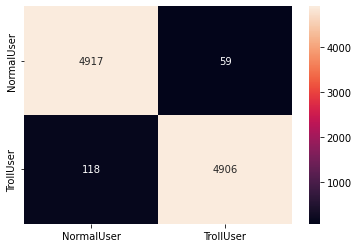

In [44]:
batch_size = 128
epochs = 100
class_labels = ['NormalUser', 'TrollUser']
lin_model, losses = train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, class_labels, lin_model, 
                optimizer, scheduler, batch_size, epochs, device)
#5 classes 0.9113
#bin 0.9818

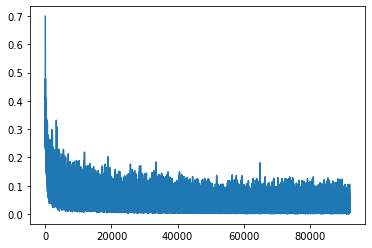

In [45]:
plt.plot(losses)
plt.show()

In [47]:
lin_model.load_state_dict(torch.load("lin_model_bin.pt"))
lin_model.eval()

LinearClassifier(
  (text_embedder): EmbeddingBag(47879, 128, mode=mean)
  (pos_embedder): EmbeddingBag(52, 8, mode=mean)
  (ent_embedder): EmbeddingBag(19, 8, mode=mean)
  (hashtag_embedder): EmbeddingBag(3934, 64, mode=mean)
  (feat_transform): Linear(in_features=4, out_features=4, bias=True)
  (hid_layer1): Linear(in_features=212, out_features=512, bias=True)
  (hid_layer2): Linear(in_features=512, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)




              precision    recall  f1-score   support

  NormalUser     0.9747    0.9891    0.9818      4976
   TrollUser     0.9891    0.9745    0.9818      5024

    accuracy                         0.9818     10000
   macro avg     0.9819    0.9818    0.9818     10000
weighted avg     0.9819    0.9818    0.9818     10000







Final Test Acc: 0.98180002


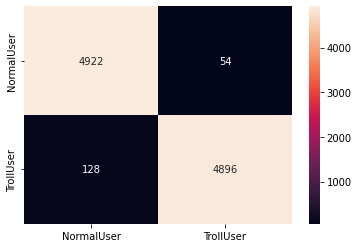

In [48]:
test_acc = test(x_text[:10000], x_pos[:10000], x_ent[:10000], x_hashtag[:10000], x_feats[:10000], y_bin[:10000], 
                lin_model, class_labels, print_confusion=True)

print('\n\n\nFinal Test Acc: %.8f' % (test_acc))

In [ ]:
#distributed embeddings

In [ ]:
def train_w2v(texts, model_path, vec_dim=128, window=5):
    model = Word2Vec(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained word2vec model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model


def train_ft(texts, model_path, vec_dim=128, window=5):
    model = FastText(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained fasttext model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model

In [ ]:
lemma_texts = [[t for t in l.split(' ') if t and not t[0]=='#'] for l in lemmas]

In [ ]:
w2v_lemma_128_model = train_w2v(lemma_texts, model_path='w2v_lemmas_128.model', vec_dim=128, window=5)

In [ ]:
ft_lemmas_128_model = train_ft(lemma_texts, model_path='ft_lemmas_128.model', vec_dim=128, window=5)

In [ ]:
#multi feature model

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, hid1_size, hid2_size, out_size, text_vocab_size, text_emb_dim, 
                 pos_vocab_size, pos_emb_dim, ent_vocab_size, ent_emb_dim, 
                 hashtag_vocab_size, hashtag_emb_dim, in_feat_dim, out_feat_dim):
        super().__init__()
        self.text_embedder = nn.EmbeddingBag(text_vocab_size, text_emb_dim)
        self.pos_embedder = nn.EmbeddingBag(pos_vocab_size, pos_emb_dim)
        self.ent_embedder = nn.EmbeddingBag(ent_vocab_size, ent_emb_dim)
        self.hashtag_embedder = nn.EmbeddingBag(hashtag_vocab_size, hashtag_emb_dim)
        self.feat_transform = nn.Linear(in_feat_dim, out_feat_dim)
        
        self.hid_layer1 = nn.Linear(text_emb_dim + pos_emb_dim + ent_emb_dim + hashtag_emb_dim + out_feat_dim, hid1_size)
        self.hid_layer2 = nn.Linear(hid1_size, hid2_size)
        self.out_layer = nn.Linear(hid2_size, out_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(hid1_size)
        self.batchnorm2 = nn.BatchNorm1d(hid2_size)
        
        
    def forward(self, x_text, x_pos, x_ent, x_hashtag, x_feats):
        text_emb = self.text_embedder(x_text)
        pos_emb = self.pos_embedder(x_pos)
        ent_emb = self.ent_embedder(x_ent)
        hashtag_emb = self.hashtag_embedder(x_hashtag)
        feat_trans = self.feat_transform(x_feats)
        
        x = torch.cat((text_emb, pos_emb, ent_emb, hashtag_emb, feat_trans), dim=1)
        x = self.dropout(x)
        
        x = self.relu(self.hid_layer1(x))
        x = self.batchnorm1(x)
        
        x = self.relu(self.hid_layer2(x))
        x = self.batchnorm2(x)
        
        x = self.out_layer(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
# create index mappings for embedding types

In [ ]:
def get_feature2idx_dicts(feats, word_model):
    word2idx = {}
    for i in range(len(word_model.wv.vocab)):
        word2idx[word_model.wv.index2word[i]] = i

    pos2idx = {}
    i=1
    for feat in feats:
        for pos in feat['pos'].split(' '):
            if not pos:
                continue
            if pos not in pos2idx:
                pos2idx[pos] = i
                i+=1
    pos2idx['<PAD>'] = 0

    ent2idx = {}
    i=1
    for feat in feats:
        for et in feat['ent_types']:
            #skip some bogus entity types
            if not et or not et.isupper():
                continue
            if et not in ent2idx:
                ent2idx[et] = i
                i+=1
    ent2idx['<PAD>'] = 0

    #only use hashtags with over 10 occurrences
    hashtags = []
    for feat in feats:
        hashtags.extend(feat['hashtags'])

    hashtag_cts = Counter(hashtags)
    hashtag_cts = {h:c for h,c in hashtag_cts.items() if c>=10}

    hashtag2idx = {h:i+1 for i,h in enumerate(hashtag_cts.keys())}
    hashtag2idx['<PAD>'] = 0

    feat_fields = ['emoji_ratio', 'link_ratio', 'user_ratio', 'oov_ratio']
    
    return word2idx, pos2idx, ent2idx, hashtag2idx, feat_fields

In [ ]:
get_feature2idx_dicts(w2v_lemma_128_model)

In [ ]:
word2idx = {}
for i in range(len(w2v_lemma_128_model.wv.vocab)):
    word2idx[w2v_lemma_128_model.wv.index2word[i]] = i
#word2idx['<PAD>'] = 0
idx2word = {i:w for w,i in word2idx.items()}

In [ ]:
pos2idx = {}
i=1
for feat in feats:
    for pos in feat['pos'].split(' '):
        if not pos:
            continue
        if pos not in pos2idx:
            pos2idx[pos] = i
            i+=1
pos2idx['<PAD>'] = 0
pos2idx

In [ ]:
ent2idx = {}
i=1
for feat in feats:
    for et in feat['ent_types']:
        if not et or not et.isupper():
            continue
        if et not in ent2idx:
            ent2idx[et] = i
            i+=1
ent2idx['<PAD>'] = 0
ent2idx

In [ ]:
hashtags = []
for feat in feats:
    hashtags.extend(feat['hashtags'])
    
hashtag_cts = Counter(hashtags)
hashtag_cts = {h:c for h,c in hashtag_cts.items() if c>=10}

hashtag2idx = {h:i+1 for i,h in enumerate(hashtag_cts.keys())}
hashtag2idx['<PAD>'] = 0

len(hashtag_cts)

In [ ]:
feat_fields = ['emoji_ratio', 'link_ratio', 'user_ratio', 'oov_ratio']

In [ ]:
class_labels = ['NewsFeed', 'NormalUser', 'RightTroll', 'LeftTroll', 'HashtagGamer']
#class_labels = ['NormalUser', 'TrollUser']
lab2idx = {l:i for i,l in enumerate(sorted(class_labels))}
idx2lab = {i:l for l,i in lab2idx.items()}
lab2idx

In [ ]:
lin_model = LinearClassifier(hid1_size=512, hid2_size=128, out_size=5, 
                             text_vocab_size=len(word2idx), text_emb_dim=w2v_lemma_128_model.wv.vector_size, 
                             pos_vocab_size=len(pos2idx), pos_emb_dim=8,
                             ent_vocab_size=len(ent2idx), ent_emb_dim=8, 
                             hashtag_vocab_size=len(hashtag2idx), hashtag_emb_dim=64, 
                             in_feat_dim=len(feat_fields), out_feat_dim=len(lab2idx))

In [ ]:
lin_model.text_embedder.weight.data.copy_(torch.FloatTensor(w2v_lemma_128_model.wv.vectors))
lin_model.text_embedder.weight.requires_grad = False

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
lr = 1e-2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lin_model.to(device)
lin_model.train()

optimizer = optim.Adam(lin_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4)

In [ ]:
seq_len = 30
ent_seq_len = 2
hashtag_seq_len = 2
x_text = []
x_pos = []
x_ent = []
x_hashtag = []
x_feats = []
y = []
for feat in feats:
    if feat['type'] not in lab2idx:
        continue
        
    s = [word2idx[t] for t in feat['lemmas'].split(' ') if t and t in word2idx] + [word2idx['pad']]*seq_len
    x_text.append(torch.tensor(s[:seq_len]))
    
    s = [pos2idx[t] for t in feat['pos'].split(' ') if t and t in pos2idx] + [pos2idx['<PAD>']]*seq_len
    x_pos.append(torch.tensor(s[:seq_len]))
    
    s = [ent2idx[t] for t in feat['ent_types'] if t and t in ent2idx] + [ent2idx['<PAD>']]*ent_seq_len
    x_ent.append(torch.tensor(s[:ent_seq_len]))
    
    s = [hashtag2idx[t] for t in feat['hashtags'] if t and t in hashtag2idx] + [hashtag2idx['<PAD>']]*hashtag_seq_len
    x_hashtag.append(torch.tensor(s[:hashtag_seq_len]))
    
    x_feats.append(torch.tensor([feat[f] for f in feat_fields]))
    
    y.append(lab2idx[feat['type']])
    
x_text = torch.vstack(x_text)
x_pos = torch.vstack(x_pos)
x_ent = torch.vstack(x_ent)
x_hashtag = torch.vstack(x_hashtag)
x_feats = torch.vstack(x_feats)
y = torch.tensor(y)

torch.save(x_text, 'x_text.pt')
torch.save(x_pos, 'x_pos.pt')
torch.save(x_ent, 'x_ent.pt')
torch.save(x_hashtag, 'x_hashtag.pt')
torch.save(x_feats, 'x_feats.pt')
torch.save(y, 'y.pt')

x_text.size(), x_pos.size(), x_ent.size(), x_hashtag.size(), x_feats.size(), y.size(), x_text[0]

In [ ]:
y = torch.load('y.pt')

In [ ]:
labs = ['NewsFeed', 'NormalUser', 'RightTroll', 'LeftTroll', 'HashtagGamer']
y_bin = []
for feat in feats:
    if feat['type'] not in labs:
        continue
    y_bin.append(0 if feat['type']=='NormalUser' else 1)
len(y_bin), Counter(y_bin)

In [ ]:
y_bin = torch.tensor(y_bin)
torch.save(y_bin, 'y_bin.pt')

In [ ]:
def train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y, class_labels, model, 
                optimizer, scheduler, criterion, batch_size, epochs, device):
    x_text_test = x_text[:10000]
    x_text_cv = x_text[10000:20000]
    x_text_train = x_text[20000:]

    x_pos_test = x_pos[:10000]
    x_pos_cv = x_pos[10000:20000]
    x_pos_train = x_pos[20000:]

    x_ent_test = x_ent[:10000]
    x_ent_cv = x_ent[10000:20000]
    x_ent_train = x_ent[20000:]

    x_hashtag_test = x_hashtag[:10000]
    x_hashtag_cv = x_hashtag[10000:20000]
    x_hashtag_train = x_hashtag[20000:]

    x_feats_test = x_feats[:10000]
    x_feats_cv = x_feats[10000:20000]
    x_feats_train = x_feats[20000:]

    y_test = y[:10000]
    y_cv = y[10000:20000]
    y_train = y[20000:]
    
    x_text_train_batches = [x_text_train[i*batch_size:(i+1)*batch_size] for i in range((x_text_train.shape[0]//batch_size) + 1)]
    x_pos_train_batches = [x_pos_train[i*batch_size:(i+1)*batch_size] for i in range((x_pos_train.shape[0]//batch_size) + 1)]
    x_ent_train_batches = [x_ent_train[i*batch_size:(i+1)*batch_size] for i in range((x_ent_train.shape[0]//batch_size) + 1)]
    x_hashtag_train_batches = [x_hashtag_train[i*batch_size:(i+1)*batch_size] for i in range((x_hashtag_train.shape[0]//batch_size) + 1)]
    x_feats_train_batches = [x_feats_train[i*batch_size:(i+1)*batch_size] for i in range((x_feats_train.shape[0]//batch_size) + 1)]
    y_train_batches = [y_train[i*batch_size:(i+1)*batch_size] for i in range((y_train.shape[0]//batch_size) + 1)]
    
    best_cv_acc = 0
    losses = []
    no_improvement = 0
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        
        #idx = list(range(len(x_text_train_batches)))
        #random.shuffle(idx)
        #x_batches = [x_batches[i] for i in idx]
        #y_batches = [y_batches[i] for i in idx]
        
        for i in range(len(x_text_train_batches)):
            optimizer.zero_grad()

            y_pred = model(x_text_train_batches[i].to(device),
                           x_pos_train_batches[i].to(device), 
                           x_ent_train_batches[i].to(device),
                           x_hashtag_train_batches[i].to(device), 
                           x_feats_train_batches[i].to(device))

            #y_pred = torch.argmax(y_pred, dim=1).float().unsqueeze(1)
            #loss = criterion(y_pred, y_train_batches[i])#)
            loss = F.nll_loss(y_pred, y_train_batches[i])
            acc = binary_acc(y_pred, y_train_batches[i].float())#.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            losses.append(loss.item())
            
            if i and i%1000==0:
                print('  ...Batch %d\tEpoch %d\tLoss: %.8f\tTrain Acc: %.8f' % (
                    i, epoch, epoch_loss/i, epoch_acc/i))
                losses.append(epoch_loss/i)
        
        cv_acc = test(x_text_cv, x_pos_cv, x_ent_cv, x_hashtag_cv, x_feats_cv, y_cv, 
                      model, class_labels)
        if cv_acc>best_cv_acc:
            print('\n *** CV Accuracy Improved: %.4f -> %.4f ***' % (best_cv_acc, cv_acc))
            torch.save(model.state_dict(), 'lin_model_bin.pt')
            best_cv_acc=cv_acc
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= 10:
            break
            
        scheduler.step(cv_acc)
            
        print('\nEpoch %d\tLoss: %.8f\tTrain Acc: %.8f\tCV Acc: %.8f\tNo Improvement: %d' % (
            epoch, epoch_loss/len(x_text_train_batches), epoch_acc/len(x_text_train_batches), cv_acc, no_improvement))
        
    test_acc = test(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test, y_test, 
                    model, class_labels, print_confusion=True)
    print('\n\n\nFinal Test Acc: %.8f' % (test_acc))
        
    return model, losses
        
        
def binary_acc(y_pred, y_test):
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    cor = (y_pred == y_test).int().sum()
    acc = cor/y_test.size()[0]
    
    return acc


def test(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test, y_test, 
         model, class_labels, print_confusion=False):
    model.eval()
    
    with torch.no_grad():
        y_pred = model(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test)
        y_pred = torch.argmax(y_pred, dim=1).cpu()
    
    print('\n\n')
    print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
    print('\n\n')
    
    if print_confusion:
        cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
        f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

    cor = (y_pred == y_test).int().sum()
    acc = cor/y_test.size()[0]
    
    model.train()
    
    return acc

In [ ]:
batch_size = 128
epochs = 100
class_labels = ['NormalUser', 'TrollUser']
lin_model, losses = train_model(x_text, x_pos, x_ent, x_hashtag, x_feats, y_bin, class_labels, lin_model, 
                optimizer, scheduler, criterion, batch_size, epochs, device)
#0.9113

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
lin_model.load_state_dict(torch.load("lin_model.pt"))
lin_model.eval()

In [ ]:
feats[0]

In [ ]:
test_acc = test(x_text[:10000], x_pos[:10000], x_ent[:10000], x_hashtag[:10000], x_feats[:10000], y[:10000], 
                lin_model, class_labels, print_confusion=True)

print('\n\n\nFinal Test Acc: %.8f' % (test_acc))

In [ ]:
#binary accuracy
lin_model.eval()
    
with torch.no_grad():
    y_pred = lin_model(x_text_test, x_pos_test, x_ent_test, x_hashtag_test, x_feats_test)
    y_pred = torch.argmax(y_pred, dim=1).cpu()

In [ ]:
lab2idx

In [ ]:
#y_pred.size()
ys= [0 if y==3 else 1 for y in y_pred.tolist()]
Counter(ys)

In [ ]:
print('\n\n')
print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
print('\n\n')

if print_confusion:
    cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
    f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

cor = (y_pred == y_test).int().sum()
acc = cor/y_test.size()[0]

In [ ]:
#visualize model

In [ ]:
from torchviz import make_dot
#you need to explicitly set the path for this lib
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [ ]:
out = lin_model(x_text[:10], x_pos[:10], x_ent[:10], x_hashtag[:10], x_feats[:10])

In [ ]:
make_dot(out, params=dict(list(lin_model.named_parameters()))).render("linear_model", format="jpg")

In [ ]:
# sum tfidf weighted word vecs

In [ ]:
def get_sum_tfidf_weighted_word_vectors(texts, word_model, tfidf, tfidf_vocab):
    sum_vecs = []
    eps = 0.01
    
    for i in range(len(texts)):
        wts = []
        vecs = []
        
        for tk in texts[i].split(' '):
            if tk not in word_model.wv:
                continue

            vecs.append(word_model.wv[tk])

            if tk not in tfidf_vocab:
                wts.append(eps)
            else:
                wts.append(tfidf[i, tfidf_vocab.index(tk)])
        
        wts = np.array(wts)
        if not vecs:
            #just add random word vec
            #idx = random.randint(0,len(word_model.wv.vocab)-1)
            #sum_vecs.append(word_model.wv[idx])
            sum_vecs.append(np.ones(word_model.wv.vector_size)*0.01)
        else:
            wt_ttl = np.sum(wts)
            wts /= wt_ttl
            vecs = np.vstack(vecs)
            sum_vecs.append(np.dot(wts, vecs))
            #sum_w2v_vecs.append(np.sum([vecs[i]*wts[i] for i in range(len(wts))], axis=0))
        #labs.append(labels[i])
        
        if i and i%1000==0:
            print(i)
    return sum_vecs

In [ ]:
sum_tfidf_weighted_w2v = get_sum_tfidf_weighted_word_vectors(lemmas[:10000], w2v_lemma_128_model, tfidf_lemmas, lemma_vocab)

In [ ]:
sum_tfidf_weighted_w2v_vecs = np.vstack(sum_tfidf_weighted_w2v)

In [ ]:
feats[0]

In [ ]:
class LSTMPOSTagger(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        #reference: https://stackoverflow.com/questions/62291303/pytorch-loading-word-vectors-into-field-vocabulary-vs-embedding-layer
        # Define an embedding layer that converts the words to embeddings based on GloVe.
        #self.embedding = nn.Embedding.from_pretrained(TEXT.vocab.vectors, padding_idx=pad_idx)
        self.embedding = nn.Embedding(TEXT.vocab.vectors.size(0), TEXT.vocab.vectors.size(1), padding_idx=pad_idx)
        
        # Define a bi-directional LSTM layer with the hyperparameters. 
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, 
                            batch_first=True, bidirectional=bidirectional)
        
        # Define a dropout layer that helps in regularization
        self.dropout = nn.Dropout(dropout)
        
        # Define a Linear layer which can associate lstm output to the final output 
        self.fc = nn.Linear(hidden_dim*2, output_dim) # *2 for bidirectional output from lstm
        
        
    def forward(self, text):
        predictions = []
    
        # pass text through embedding layer (sent len x batch size)
        emb = self.embedding(text)
        #print('emb', emb.size()) #batch x seq x dim?
        
        # pass embeddings into LSTM  batch x seq x dim
        final_hid, _ = self.lstm(emb) #embeds.view(len(sentence), 1, -1)  
        #print('final_hid', final_hid.size()) #(N, L, D * H_{out})  batch x seq x 2*hid
        
        #print('final hid compressed', )
        # pass the LSTM output to dropout and fully connected linear layer
        predictions = self.fc(final_hid) #lstm_out.view(len(sentence), -1)  do we compress seq into the batch?
        #print('predictions', predictions.size()) #final_hid.view(-1, 2*self.hidden_dim)
        
        # we use our outputs to make a prediction of what the tag should be
        
        # predictions = [sent len, batch size, output dim]
        
        return predictions

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100 #glove dim
HIDDEN_DIM = 256 #128
OUTPUT_DIM = len(UD_TAGS.vocab)
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTMPOSTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, std=0.1)
model.apply(init_weights)

# initializing model embeddings with glove word vectors
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

# making the padding embeddings as all zero, as we don't want to learn paddings.
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# optimizer to train the model
optimizer = optim.Adam(model.parameters(), lr=0.001)
# ignoring the padding in our loss calculation
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
# use gpu if available, These lines move your model to gpu from cpu if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 50

no_improvement = 0
prev_val_loss = 99999999

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_epoch_loss = 0
    train_epoch_acc = 0
    print(f'Epoch: {epoch+1:02}\n')
    num_batches=0
    for batch in train_iterator:
        num_batches+=1
        
        # returns a batch of text to train on (sent len, batch size)
        text = batch.text
        tags = batch.udtags
        
        # Add a command that makes the optimizer with zero gradients for each iteration 
         # Add code line
        optimizer.zero_grad()
        
        # Add a command that feeds the batch to the model
         # Add code line
        predictions = model(text)
        
        # predictions = (sent len, batch size, output dim)
          # tags = (sent len, batch size)
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        # Add a command that calculates loss
         # Add code line
        train_loss = criterion(predictions, tags)
        train_epoch_loss += train_loss.item()
        
        # Make use of the categorical accuracy and calculate accuracy
         # Add code line
        train_acc = categorical_accuracy(predictions, tags)
        train_epoch_acc += train_acc.item()
        
        # Add a command that calculates gradients
         # Add code line
        train_loss.backward()
        
        # Add a command that updates the weights by taking steps 
         # Add code line
        optimizer.step()
        
        
    # Calculate loss
    print('%d batches' % num_batches)
    train_epoch_loss /= num_batches
    train_epoch_acc /= num_batches
        
    print(f'\t [Train Loss] : {train_epoch_loss:.3f} | [Train Acc] : {train_epoch_acc*100:.2f}%\n')
    
    val_epoch_loss = 0
    val_epoch_acc = 0
    
    # Add a command that moves the model to validation mode
    model.eval()
    
    with torch.no_grad():
        num_val_batches=0
        for batch in valid_iterator:
            num_val_batches+=1
            
            text = batch.text
            tags = batch.udtags
        
            # Add the same command that feeds the batch to the model
            # Add code line
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            # Add the same command that calculates loss
            # Add code line
            val_loss = criterion(predictions, tags)
            val_epoch_loss += val_loss.item()
            
            # Make use of the categorical accuracy function and calculate accuracy
             # Add code line
            val_acc = categorical_accuracy(predictions, tags)
            val_epoch_acc += val_acc.item()
            
        # Calculate validation loss
        print('%d val batches' % num_val_batches)
        val_epoch_loss /= num_val_batches
        val_epoch_acc /= num_val_batches
        
        if val_epoch_loss < prev_val_loss:
            prev_val_loss = val_epoch_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= 10:
                print('No improvement, stopping early')
                break
            
        print(f'\t [Val Loss] : {val_epoch_loss:.3f} | [Val Acc] : {val_epoch_acc*100:.2f}%\n')